### CNN-폐렴진단 분류

In [1]:
#https://www.kaggle.com/faizunnabi/diagnose-pneumonia

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Dropout,MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
total_images_train_normal = os.listdir('c:/workspace3/data/images/chest_xray/chest_xray/train/NORMAL/') # 정상
total_images_train_pneumonia = os.listdir('c:/workspace3/data/images/chest_xray/chest_xray/train/PNEUMONIA/') #폐렴

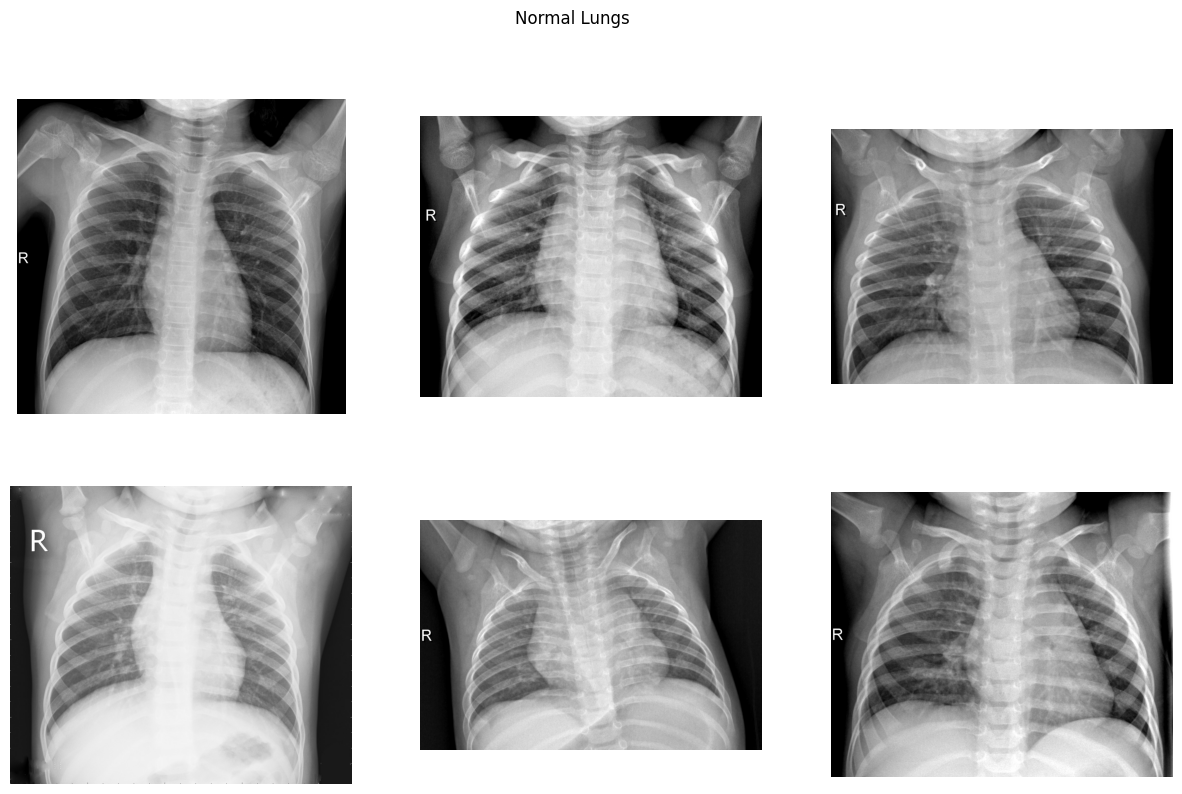

In [3]:
# 정상 폐사진

sample_normal = random.sample(total_images_train_normal,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread('c:/workspace3/data/images/chest_xray/chest_xray/train/NORMAL/'+sample_normal[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Normal Lungs')

plt.show()

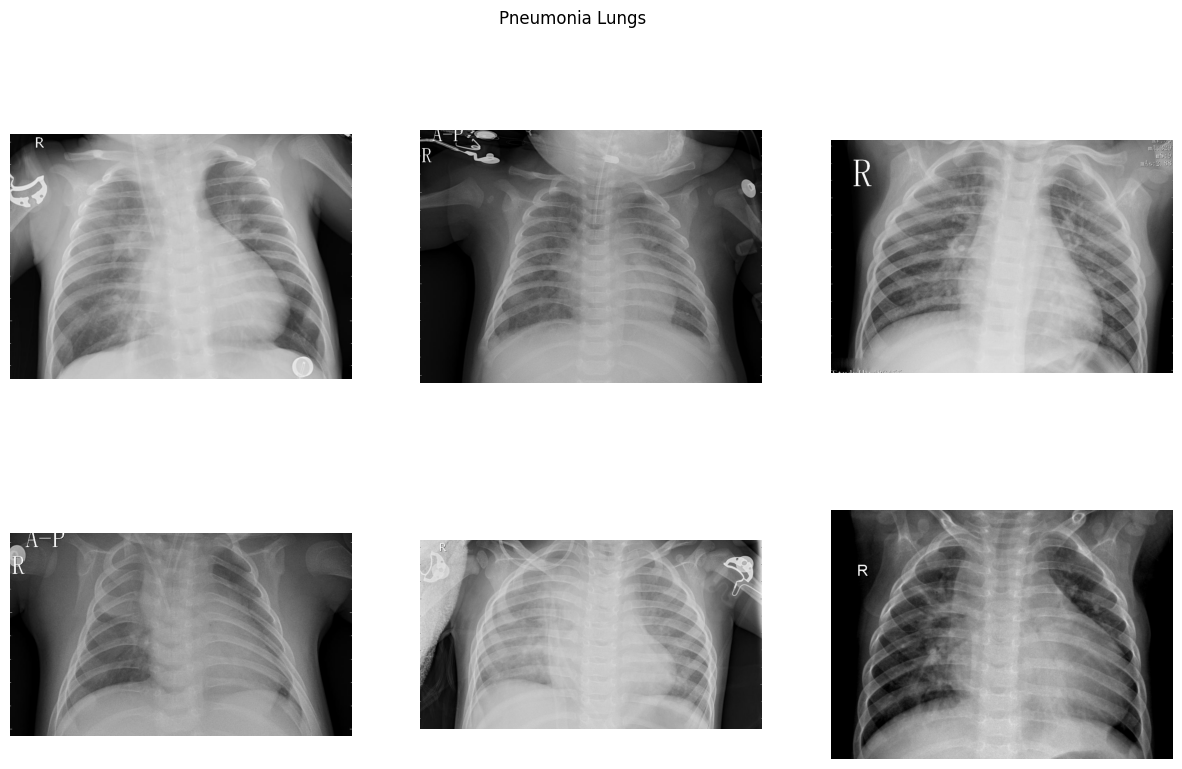

In [4]:
# 폐렴 이미지

sample_pneumonia = random.sample(total_images_train_pneumonia,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread('c:/workspace3/data/images/chest_xray/chest_xray/train/PNEUMONIA/'+sample_pneumonia[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Pneumonia Lungs')

plt.show()

In [5]:
image_height = 150
image_width = 150  
batch_size = 10    
no_of_epochs  = 2

In [6]:
model = Sequential()

model.add(Conv2D(32,(3,3),input_shape=(image_height,image_width,3),activation='relu'))

model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64,(3,3),activation='relu'))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(128,(3,3),activation='relu'))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(units=128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1,activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 73, 73, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 69, 69, 64)        36928     
                                                        

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255,     # 픽셀 값 0.0~1.0
                                   rotation_range=15,  # 15도까지 회전
                                   shear_range=0.2,    # 20%까지 기울임
                                   zoom_range=0.2      # 20%까지 확대
                                   )

val_datagen = ImageDataGenerator(rescale=1./255)      

In [8]:
training_set = train_datagen.flow_from_directory('c:/workspace3/data/images/chest_xray/chest_xray/chest_xray/train',
                                                 target_size=(image_width, image_height),
                                                 batch_size=batch_size,
                                                 class_mode='binary')

test_set = val_datagen.flow_from_directory('c:/workspace3/data/images/chest_xray/chest_xray/test',
                                            target_size=(image_width, image_height),
                                            batch_size=batch_size,
                                            class_mode='binary')

val_set = val_datagen.flow_from_directory('c:/workspace3/data/images/chest_xray/chest_xray/val',
                                            target_size=(image_width, image_height),
                                            batch_size=1,
                                            shuffle=False,
                                            class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [9]:
modelCheckpoint = ModelCheckpoint('diagnose_pneumonia_model.h5', save_best_only=True)
monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience=5)

history = model.fit_generator(training_set,
                    steps_per_epoch=5216//batch_size,
                    epochs=no_of_epochs,
                    validation_data=test_set,
                    validation_steps=624//batch_size,
                    callbacks=[monitor_val_acc, modelCheckpoint]
                   )

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_13192\680236201.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(training_set,


Epoch 1/2
521/521 [==============================] - 119s 222ms/step - loss: 0.5862 - accuracy: 0.7416 - val_loss: 0.6622 - val_accuracy: 0.6258
Epoch 2/2
521/521 [==============================] - 66s 126ms/step - loss: 0.4229 - accuracy: 0.8089 - val_loss: 0.4033 - val_accuracy: 0.8274


In [10]:
score = model.evaluate(test_set, steps=624//batch_size, verbose=1)
score

62/62 [==============================] - 5s 75ms/step - loss: 0.4042 - accuracy: 0.8274


[0.404156357049942, 0.8274193406105042]

In [11]:
print(test_set.class_indices)

{'NORMAL': 0, 'PNEUMONIA': 1}


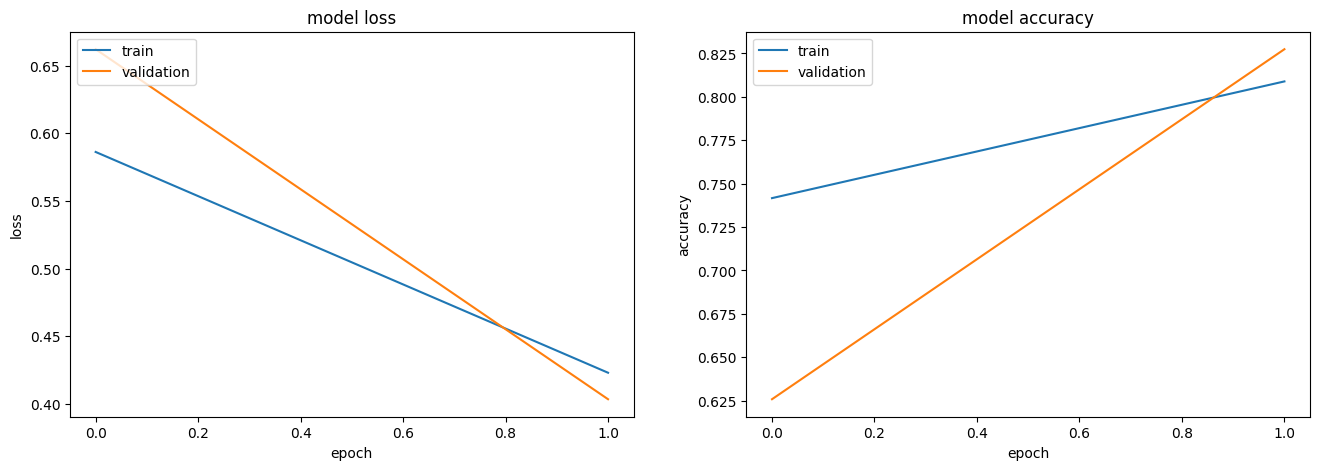

In [12]:
plt.figure(figsize=(16,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [13]:
predictions = model.predict(val_set, steps=16, verbose=1)
predictions

16/16 [==============================] - 2s 68ms/step


array([[0.65471053],
       [0.61035925],
       [0.5755425 ],
       [0.5062718 ],
       [0.9796591 ],
       [0.45675206],
       [0.43090832],
       [0.20841761],
       [0.8447775 ],
       [0.9455331 ],
       [0.8718417 ],
       [0.68576455],
       [0.6403055 ],
       [0.9512239 ],
       [0.48253027],
       [0.91303444]], dtype=float32)

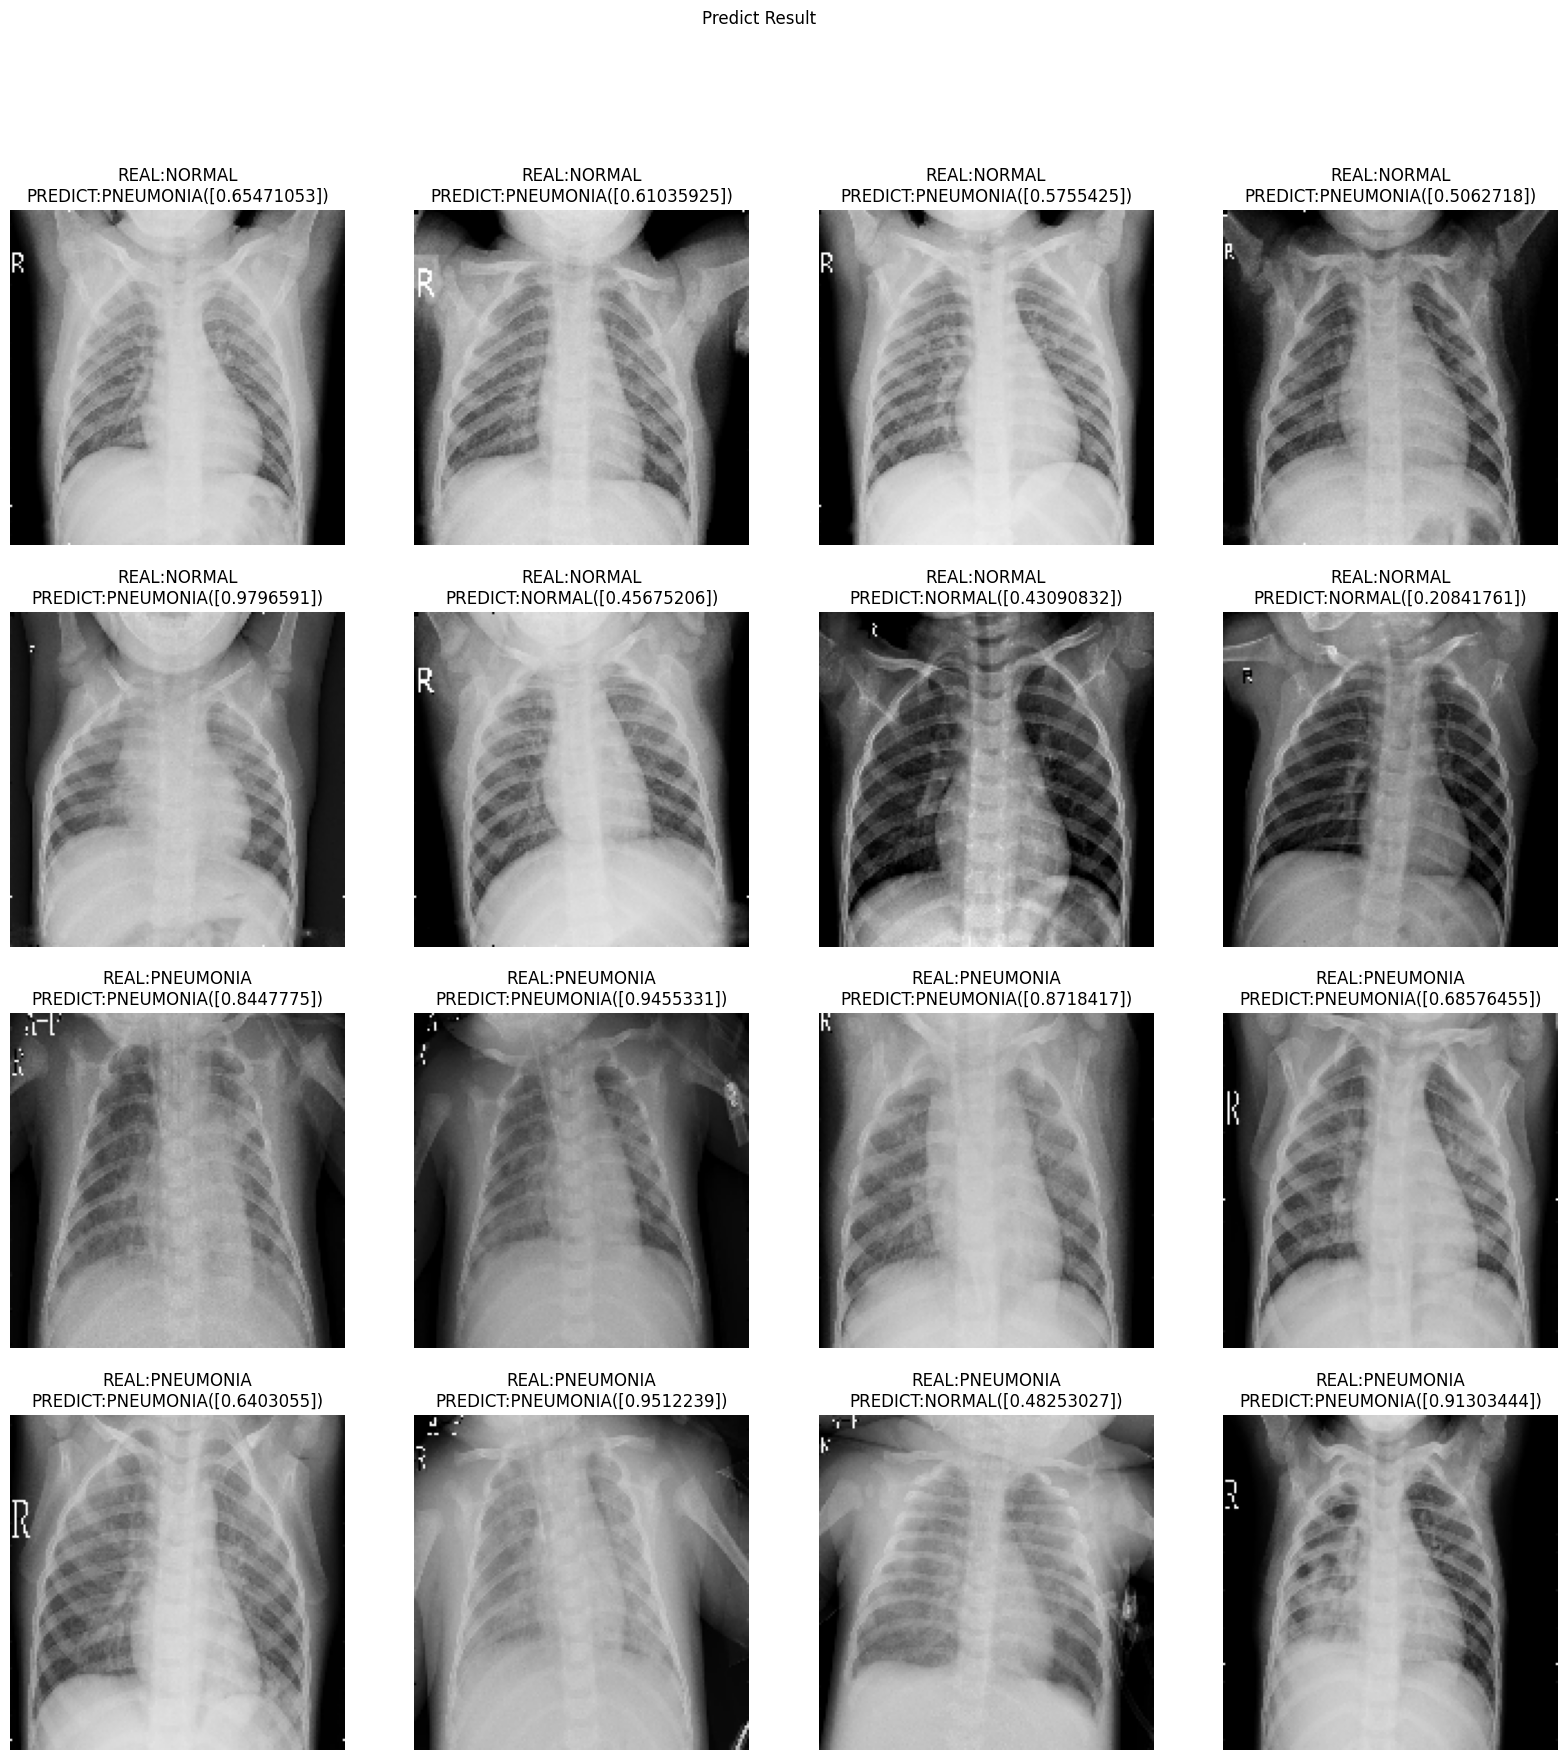

In [14]:
f,ax = plt.subplots(4,4,figsize=(20,20))

for i in range(len(predictions)):
    image, label = val_set.next()
    real_class = 'NORMAL' if int(label) == 0 else 'PNEUMONIA'      

    ax[i//4,i%4].imshow(image[0])                                  
    ax[i//4,i%4].axis('off')

    pred_class = 'PNEUMONIA' if predictions[i] > 0.5 else 'NORMAL'
    pred_prob = predictions[i]                                    

    ax[i//4,i%4].set_title('REAL:' + real_class + '\nPREDICT:' + pred_class + '(' + str(pred_prob) + ')')  
    
f.suptitle('Predict Result')

plt.show()